In [ ]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 75kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## The imports 
import numpy as np
from PIL import Image 
import cv2
from matplotlib import pyplot as plt
from scipy import linalg

In [157]:
#define Variables
IMAGE_PATH = '/content/drive/MyDrive/Machine Vision/HW3/Homework3-Files/Calib_Image.jpg'
THE_6_POINT_ALGORITHM = 6

In [158]:
# Functions
def Calculate_P(Image_location, Real_location):   # this function is for calculating the P matrix
  M = []
  num = 1
  for i in range(len(Image_location)):
    x, y = Image_location[i][0], Image_location[i][1]
    X, Y, Z = Real_location[i][0], Real_location[i][1], Real_location[i][2]
    M.append([-X, -Y, -Z, -1, 0, 0, 0, 0, x*X, x*Y, x*Z, x])
    if num != 6:
      M.append([0, 0, 0, 0, -X, -Y, -Z, -1, y*X, y*Y, y*Z, y])
    num += 1
  M = np.array(M)
  U,S,V  = np.linalg.svd(M)
  return V[-1]

    
def num_inline(new_Image_location, new_Real_location, P, threshold): # this function will count the number of inlines
  new_Real_location = np.concatenate((new_Real_location, np.ones((len(new_Real_location), 1))), axis=1)
  new_loc = np.matmul(new_Real_location, P.T)
  new_loc = new_loc / (new_loc[:, -1].reshape(-1, 1))
  new_loc = new_loc[:, :-1] 
  error = np.linalg.norm(new_Image_location - new_loc, axis = 1)
  num_inliers = np.sum(error < threshold) # comparing with threshold
  return num_inliers

In [159]:
Image = cv2.imread(IMAGE_PATH, 0)
Color_Image = cv2.imread(IMAGE_PATH)
# Key point

img_corners = cv2.goodFeaturesToTrack(Image, 600, 0.3, 300)
img_corners = img_corners.reshape((img_corners.shape[0], 2))
idx = np.argsort(img_corners[:, 0])
img_corners = img_corners[idx]
img_corners = img_corners.astype(int)

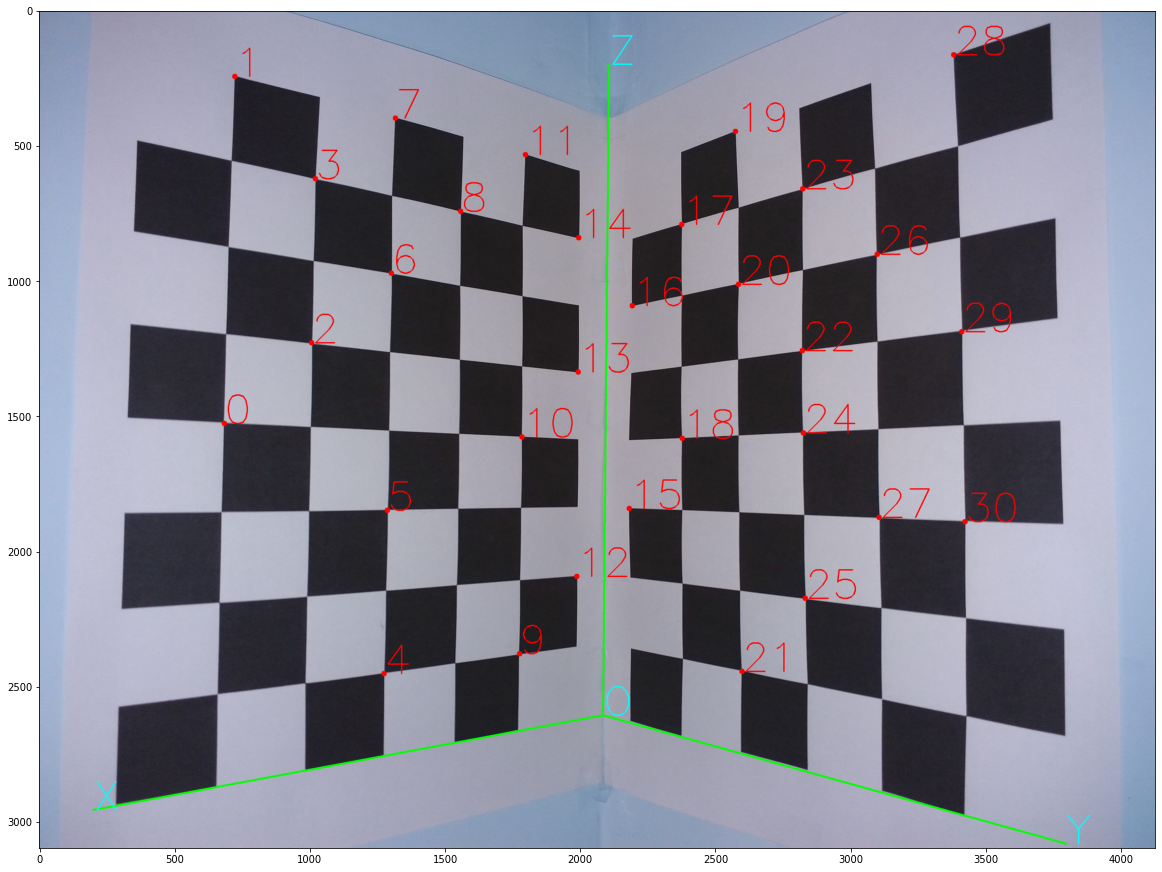

In [160]:
# Lines
Ox = 2086
Oy = 2605
# drawing the lines
cv2.line(Color_Image, (Ox, Oy), (Ox+22, 200), (0, 255, 0), thickness=5)
cv2.line(Color_Image, (Ox, Oy), (3800, 3080), (0, 255, 0), thickness=5)
cv2.line(Color_Image, (Ox, Oy), (200, 2955), (0, 255, 0), thickness=5)

cv2.putText(Color_Image, 'Z', (Ox+22, 200), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 3)
cv2.putText(Color_Image, 'O', (Ox, Oy), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 3)
cv2.putText(Color_Image, 'Y', (3800, 3080), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 3)
cv2.putText(Color_Image, 'X', (200, 2955), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 3)


# Ploting
for i, point in enumerate(img_corners):
    col, row = point.ravel()
    cv2.circle(Color_Image, (col, row), 10, (255, 0, 0), -1)
    cv2.putText(Color_Image, str(i), (col, row), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 4)
    
plt.subplots(figsize=(20, 20))
plt.imshow(Color_Image)

In [161]:
# In this part we are going to enter the location of every point
Real_location = []
Real_location.append([16.5, 0, 12])
Real_location.append([16.5, 0, 24])
Real_location.append([13.5, 0, 15])
Real_location.append([13.5, 0, 21])
Real_location.append([10.5, 0, 3])
Real_location.append([10.5, 0, 9])
Real_location.append([10.5, 0, 18])
Real_location.append([10.5, 0, 24])
Real_location.append([7.5, 0, 21])
Real_location.append([4.5, 0, 3])
Real_location.append([4.5, 0, 12])
Real_location.append([4.5, 0, 24])
Real_location.append([1.5, 0, 6])
Real_location.append([1.5, 0, 15])
Real_location.append([1.5, 0, 21])
Real_location.append([0, 1.5, 9])
Real_location.append([0, 1.5, 18])
Real_location.append([0, 4.5, 21])
Real_location.append([0, 4.5, 12])
Real_location.append([0, 7.5, 24])
Real_location.append([0, 7.5, 18])
Real_location.append([0, 7.5, 3])
Real_location.append([0, 10.5, 15])
Real_location.append([0, 10.5, 21])
Real_location.append([0, 10.5, 12])
Real_location.append([0, 10.5, 6])
Real_location.append([0, 13.5, 18])
Real_location.append([0, 13.5, 9])
Real_location.append([0, 16.5, 24])
Real_location.append([0, 16.5, 15])
Real_location.append([0, 16.5, 9])
Real_location = np.array(Real_location)

In [162]:
class Ransac: # We are going to make a class 
  def __init__(self, p, threshold, algorithm=THE_6_POINT_ALGORITHM):
    self.p = p
    self.threshold = threshold
    self.algorithm = algorithm
  def Run(self, Image_location, Real_location): # this function will use the ransac method to find the best fundamental matrix
    N = np.inf
    N = 20000
    n = 0
    max_inline = 0
    Best_P = 0
    while N > n: # The condition to move on
      idx = np.random.choice(Image_location.shape[0], size=self.algorithm, replace=False)
      new_Image_location = Image_location[idx]
      new_Real_location = Real_location[idx]
      P = (Calculate_P(new_Image_location, new_Real_location)).reshape(3, 4)
      inline = num_inline(Image_location, Real_location, P, self.threshold)
      if inline == len(Image_location): # if all of them are inline then we can go out
        return P, inline
      if inline > max_inline:
        Best_P = P
        max_inline = inline
      N = np.log(1-self.p) / np.log(1 - np.power((inline)/len(Image_location),self.algorithm))
      n += 1
      
    return Best_P, max_inline


In [163]:
My_Model = Ransac(0.99, np.sqrt(5.99))
P, L = My_Model.Run(img_corners, Real_location)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


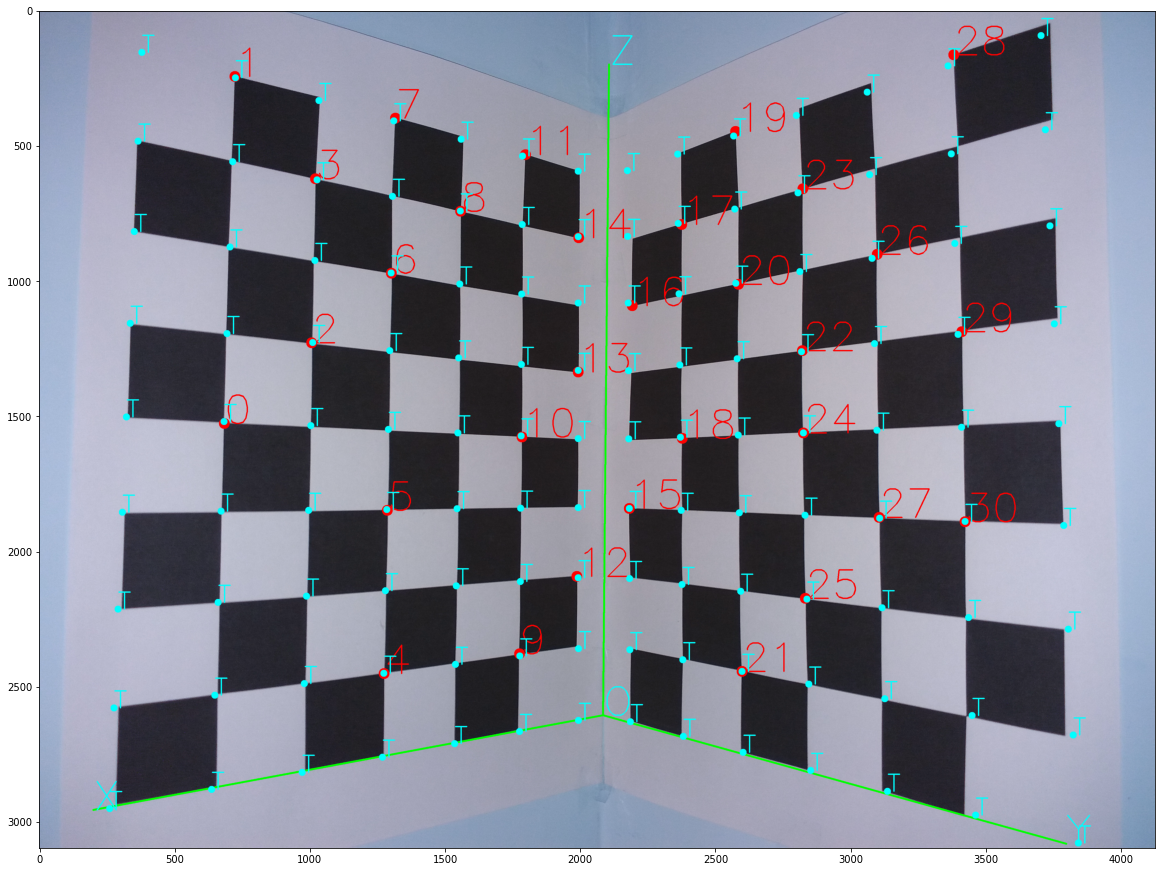

In [164]:
Image = cv2.imread(IMAGE_PATH, 0)
Color_Image = cv2.imread(IMAGE_PATH)
# key points
img_corners = cv2.goodFeaturesToTrack(Image, 600, 0.3, 300)
img_corners = img_corners.reshape((img_corners.shape[0], 2))
idx = np.argsort(img_corners[:, 0])
img_corners = img_corners[idx]
img_corners = img_corners.astype(int)

# Lines
Ox = 2086
Oy = 2605

cv2.line(Color_Image, (Ox, Oy), (Ox+22, 200), (0, 255, 0), thickness=5)
cv2.line(Color_Image, (Ox, Oy), (3800, 3080), (0, 255, 0), thickness=5)
cv2.line(Color_Image, (Ox, Oy), (200, 2955), (0, 255, 0), thickness=5)

cv2.putText(Color_Image, 'Z', (Ox+22, 200), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 3)
cv2.putText(Color_Image, 'O', (Ox, Oy), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 3)
cv2.putText(Color_Image, 'Y', (3800, 3080), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 3)
cv2.putText(Color_Image, 'X', (200, 2955), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 3)


# Plot
for i, point in enumerate(img_corners):
  col, row = point.ravel()
  cv2.circle(Color_Image, (col, row), 20, (255, 0, 0), -1)
  cv2.putText(Color_Image, str(i), (col, row), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 4)
  temp = np.append(Real_location[i], 1)
  loc = np.matmul(P, temp.reshape((4, 1)))
  example = loc / loc[2]  
  cv2.circle(Color_Image, (int(example[0]), int(example[1])), 10, (255, 255, 0), -1)

# This part we will make a lot of input values for all the edges and want to estimate the location
for i in range(9):
  for j in range(7):
    temp = np.array([1.5 + 3 * j, 0, 0 + 3 * i, 1])
    loc = np.matmul(P, temp.reshape((4, 1)))
    example = loc / loc[2]  
    cv2.circle(Color_Image, (int(example[0]), int(example[1])), 13, (0, 255, 255), -1)
    cv2.putText(Color_Image, "T", (int(example[0]), int(example[1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 255), 4)


for i in range(9):
  for j in range(7):
    temp = np.array([0, 1.5 + 3 * j, 0 + 3 * i, 1])
    loc = np.matmul(P, temp.reshape((4, 1)))
    example = loc / loc[2]  
    cv2.circle(Color_Image, (int(example[0]), int(example[1])), 13, (0, 255, 255), -1)
    cv2.putText(Color_Image, "T", (int(example[0]), int(example[1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 255), 4)

plt.subplots(figsize=(20, 20))
plt.imshow(Color_Image)